In [1]:
from dataclasses import dataclass

import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from src.architectures.dvi import DVI
from src.components.cdvi.cmcd import CMCD
from src.components.cdvi.dis import DIS
from src.components.cdvi.ula import ULA
from src.components.control.aggr_control import AggrControl
from src.components.encoder.proj_encoder import ProjEncoder
from src.components.schedule.annealing_schedule import AnnealingSchedule
from src.components.schedule.cos_noise_schedule import CosineNoiseSchedule
from src.components.schedule.noise_schedule import NoiseSchedule
from src.components.schedule.step_size_schedule import StepSizeSchedule
from src.evaluation.visualization.visualize_dvi import visualize_dvi
from src.training.dvi_trainer import DVITrainerContext
from src.utils.datasets import ContextTestDataset
from src.utils.distros import ContextualGMM

In [2]:
device = torch.device("cpu") 

In [3]:
@dataclass
class Config():
    num_steps = 16
    c_dim = 1
    z_dim = 1
    h_dim = 32
    num_layers = 3
    non_linearity = "GELU"
    use_score = False
    learning_rate = 3e-3
    size = 64
    batch_size = 64

config = Config()

In [4]:
dataset = ContextTestDataset(size=config.size, c_dim=config.c_dim, sampling_factor=0)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
contextual_target = lambda context, _: ContextualGMM(context, offsets=(5, -5), scales=(1, 1), weights=(0.3, 0.7))

encoder = ProjEncoder(
    c_dim=config.c_dim, 
    h_dim=config.h_dim
)

control = AggrControl(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps,
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    use_score=config.use_score,
    use_error=False
)

noise_schedule = NoiseSchedule(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    device=device,
    # max=10
)

step_size_schedule = StepSizeSchedule(
    num_steps=config.num_steps, 
    device=device
)

annealing_schedule = AnnealingSchedule(
    num_steps=config.num_steps, 
    device=device
)

cdvi = DIS(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    control=control, 
    step_size_schedule=step_size_schedule,
    noise_schedule=noise_schedule,
    annealing_schedule=annealing_schedule,
    use_score=config.use_score,
    use_error=False,
    device=device, 
)

# cdvi = CMCD(
#     z_dim=config.z_dim, 
#     num_steps=config.num_steps, 
#     control=control,
#     step_size_schedule=step_size_schedule,
#     noise_schedule=noise_schedule,
#     annealing_schedule=annealing_schedule,
#     device=device, 
# )

# cdvi = ULA(
#     z_dim=config.z_dim, 
#     num_steps=config.num_steps, 
#     step_size_schedule=step_size_schedule,
#     noise_schedule=noise_schedule,
#     annealing_schedule=annealing_schedule,
#     device=device, 
# )

model = DVI(
    encoder=encoder,
    cdvi=cdvi,
    contextual_target=contextual_target
).to(device)

In [6]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=config.learning_rate)

trainer = DVITrainerContext(
    model=model,
    device=device,
    dataset=dataset,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    scheduler=None,
    generator=torch.Generator(),
    wandb_logging=False,
    num_subtasks=1,
    num_samples=1,
    val_grad_off=True
)

In [9]:
train = True

if train:
    num_epochs = 500
    trainer.train(
        num_epochs=num_epochs, 
        max_clip_norm=None,
        alpha=None
    )

100%|██████████| 1/1 [00:00<00:00, 17.50it/s, epoch=499, loss=0.429]


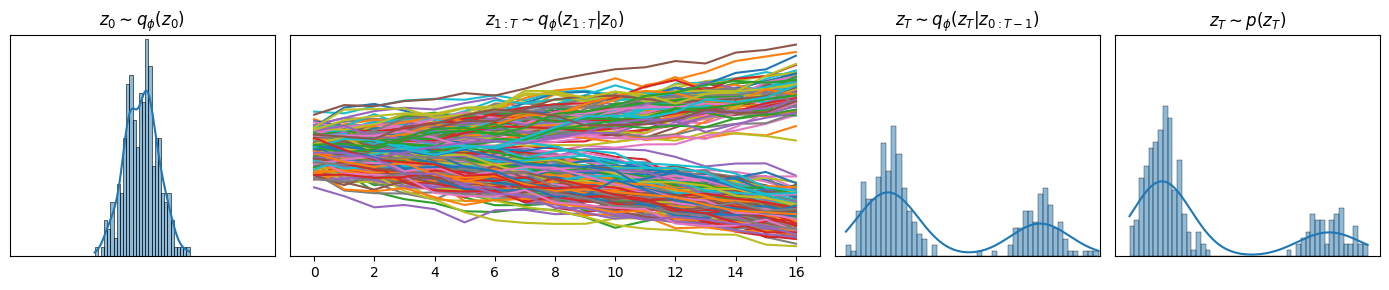

In [12]:
visualize_dvi(config, device, model, dataset, num_samples=256)